<a href="https://colab.research.google.com/github/Gabriele90/ML-for-histopathology/blob/main/Multi_class_texture_analysis_in_colorectal_cancer_histology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

Automatic recognition of different tissue types in histological images is an essential part in the digital pathology toolbox. Texture analysis is commonly used to address this problem; mainly in the context of estimating the tumour/stroma ratio on histological samples. However, although histological images typically contain more than two tissue types, only few studies have addressed the multi-class problem. For colorectal cancer, one of the most prevalent tumour types, there are in fact no published results on multiclass texture separation. In this project I followed the classification approach of Kather at al. but istead of using the 4 classification models described in the paper(nearest neighbour, linear SVM,radial-basis function SVM, and decision trees) I used the VGG16 model with the Transfer learning/fine tuning method. As a result, I found an optimal classification strategy that was comparable with the 4 mentioned methods (87.4% accuracy for eight classes),  with an **accuracy of 87.5%**.

Classification accuracy is given as the mean of a 3 experimental runs with
80% of the dataset as training and 10% of the dataset as testing and validation group.

**Objectives**

From a deep learning perspective, the image classification problem can be solved through transfer learning. Actually, several state-of-the-art results in image classification are based on transfer learning solutions. Transfer learning is a popular method in computer vision because it allows us to build accurate models in a timesaving way. With transfer learning, instead of starting the learning process from scratch, you start from patterns that have been learned when solving a different problem.
In computer vision, transfer learning is usually expressed through the use of pre-trained models. A pre-trained model is a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve. Select a pre-trained model. From the wide range of pre-trained models that are available, you pick one that looks suitable for your problem. For example, if you’re using Keras, you immediately have access to a set of models, such as VGG16. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from tensorflow.keras.metrics import Metric
from typeguard import typechecked
from typing import Optional

import cv2
import random
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D,BatchNormalization,LayerNormalization

**Data splitting**

When developing a deep learning-based method, using a rigorous evaluation process is essential to avoid overfitting to training data or the generation of fake information. In order to evaluate the performance of the network, it is generally recommended to split data into training, valid, and test sets. The training set data are used to determine the network parameters. In most cases, the network shows good performance for the training set after an iterative learning process with the proper adjustment of the network structure and its hyperparameters, due to its very high capacity. Therefore, the separate validation set is required to predict the general performance of the network. The data in the validation set should not be fed into the network because the model should have the ability to apply external data not included in the training process.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Mar 16 18:44:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Kather_texture_2016_image_tiles_5000'):
    for filename in filenames:
        os.path.join(dirname, filename)

#!pip install split_folders
#import splitfolders
#input_folder = '../input/8-class-tumor/Kather_texture_2016_image_tiles_5000'
#output_folder = './'
#splitfolders.ratio(input_folder, output_folder, seed=1337, ratio=(.8, .1, .1), group_prefix=None) 

**Dataset description**

Anonymized H&E stained CRC tissue slides were obtained from the pathology archive at the 
University Medical Center Mannheim (Heidelberg University, Mannheim, Germany). 
The following eight types of tissue were selected for analysis:

a. Tumour epithelium;

b. Simple stroma (homogeneous composition, includes tumour stroma, extra-tumoural stroma and smooth 
muscle);

c. Complex stroma (containing single tumour cells and/or few immune cells);

d. Immune cells (including immune-cell conglomerates and sub-mucosal lymphoid follicles);

e. Debris (including necrosis, hemorrhage and mucus);

f. Normal mucosal glands;

g. Adipose tissue;

h. Background (no tissue).

Together, the resulting 625× 8= 5000 images represented the training and testing set of the classification  problem.

The data can be accessed via the following DOI: 10.5281/
zenodo.53169. All source codes used for this study are available under the MIT license (http://opensource.org/licenses/MIT) and can be accessed via the following DOI: 10.5281/zenodo.53735.

**Setting the working directories**

In [ ]:
#set the path to the main dir
main_dir = "/content/drive/MyDrive/output_8_class"
#set the path to the train dir
train_dir = os.path.join(main_dir,'train')
#set the path to the test dir
test_dir = os.path.join(main_dir,'test')
#set the path to the val dir
val_dir = os.path.join(main_dir,'val')

#directory with the training msi images
train_tumor_dir = os.path.join(train_dir, '01_TUMOR')
#directory with the training mss images
train_stroma_dir = os.path.join(train_dir, '02_STROMA')
#directory with the training mss images
train_complex_dir = os.path.join(train_dir, '03_COMPLEX')
#directory with the training mss images
train_lympho_dir = os.path.join(train_dir, '04_LYMPHO')
#directory with the training mss images
train_debris_dir = os.path.join(train_dir, '05_DEBRIS')
#directory with the training mss images
train_mucosa_dir = os.path.join(train_dir, '06_MUCOSA')
#directory with the training mss images
train_adipose_dir = os.path.join(train_dir, '07_ADIPOSE')
#directory with the training mss images
train_empty_dir = os.path.join(train_dir, '08_EMPTY')

#directory with the training msi images
test_tumor_dir = os.path.join(test_dir, '01_TUMOR')
#directory with the training mss images
test_stroma_dir = os.path.join(test_dir, '02_STROMA')
#directory with the training mss images
test_complex_dir = os.path.join(test_dir, '03_COMPLEX')
#directory with the training mss images
test_lympho_dir = os.path.join(test_dir, '04_LYMPHO')
#directory with the training mss images
test_debris_dir = os.path.join(test_dir, '05_DEBRIS')
#directory with the training mss images
test_mucosa_dir = os.path.join(test_dir, '06_MUCOSA')
#directory with the training mss images
test_adipose_dir = os.path.join(test_dir, '07_ADIPOSE')
#directory with the training mss images
test_empty_dir = os.path.join(test_dir, '08_EMPTY')

#directory with the training msi images
val_tumor_dir = os.path.join(val_dir, '01_TUMOR')
#directory with the training mss images
val_stroma_dir = os.path.join(val_dir, '02_STROMA')
#directory with the training mss images
val_complex_dir = os.path.join(val_dir, '03_COMPLEX')
#directory with the training mss images
val_lympho_dir = os.path.join(val_dir, '04_LYMPHO')
#directory with the training mss images
val_debris_dir = os.path.join(val_dir, '05_DEBRIS')
#directory with the training mss images
val_mucosa_dir = os.path.join(val_dir, '06_MUCOSA')
#directory with the training mss images
val_adipose_dir = os.path.join(val_dir, '07_ADIPOSE')
#directory with the training mss images
val_empty_dir = os.path.join(val_dir, '08_EMPTY')

In [ ]:
#train categories names

train_tumor_names = os.listdir(train_tumor_dir)
print(train_tumor_names[:5])

train_stroma_names = os.listdir(train_stroma_dir)
print(train_stroma_names[:5])

train_complex_names = os.listdir(train_complex_dir)
print(train_complex_names[:5])

train_lympho_names = os.listdir(train_lympho_dir)
print(train_lympho_names[:5])

train_debris_names = os.listdir(train_debris_dir)
print(train_debris_names[:5])

train_mucosa_names = os.listdir(train_mucosa_dir)
print(train_mucosa_names[:5])

train_adipose_names = os.listdir(train_adipose_dir)
print(train_adipose_names[:5])

train_empty_names = os.listdir(train_empty_dir)
print(train_empty_names[:5])

#test categories names
test_tumor_names = os.listdir(test_tumor_dir)
print(test_tumor_names[:5])

test_stroma_names = os.listdir(test_stroma_dir)
print(test_stroma_names[:5])

test_complex_names = os.listdir(test_complex_dir)
print(test_complex_names[:5])

test_lympho_names = os.listdir(test_lympho_dir)
print(test_lympho_names[:5])

test_debris_names = os.listdir(test_debris_dir)
print(test_debris_names[:5])

test_mucosa_names = os.listdir(test_mucosa_dir)
print(test_mucosa_names[:5])

test_adipose_names = os.listdir(test_adipose_dir)
print(test_adipose_names[:5])

test_empty_names = os.listdir(test_empty_dir)
print(test_empty_names[:5])

#val categories names
val_tumor_names = os.listdir(val_tumor_dir)
print(val_tumor_names[:5])

val_stroma_names = os.listdir(val_stroma_dir)
print(val_stroma_names[:5])

val_complex_names = os.listdir(val_complex_dir)
print(val_complex_names[:5])

val_lympho_names = os.listdir(val_lympho_dir)
print(val_lympho_names[:5])

val_debris_names = os.listdir(val_debris_dir)
print(val_debris_names[:5])

val_mucosa_names = os.listdir(val_mucosa_dir)
print(val_mucosa_names[:5])

val_adipose_names = os.listdir(val_adipose_dir)
print(val_adipose_names[:5])

val_empty_names = os.listdir(val_empty_dir)
print(val_empty_names[:5])

['17269_CRC-Prim-HE-07_025.tif_Row_901_Col_151.tif', '13299_CRC-Prim-HE-02_007.tif_Row_1_Col_301.tif', '16698_CRC-Prim-HE-07_025.tif_Row_1651_Col_601.tif', '1513_CRC-Prim-HE-04_015.tif_Row_1_Col_1.tif', '14A1D_CRC-Prim-HE-03_028.tif_Row_451_Col_151.tif']
['10BF5_CRC-Prim-HE-07_026.tif_Row_1351_Col_451.tif', '11C0E_CRC-Prim-HE-07_014.tif_Row_151_Col_451.tif', '118E_CRC-Prim-HE-02_015.tif_Row_301_Col_3601.tif', '1116_CRC-Prim-HE-03.tif_Row_1351_Col_1801.tif', '112F5_CRC-Prim-HE-04.tif_Row_1_Col_3301.tif']
['139D0_CRC-Prim-HE-01_048.tif_Row_1_Col_1.tif', '13EBE_CRC-Prim-HE-03_002.tif_Row_1_Col_901.tif', '15E71_CRC-Prim-HE-09_016.tif_Row_301_Col_751.tif', '159B7_CRC-Prim-HE-05_021.tif_Row_1_Col_601.tif', '10D92_CRC-Prim-HE-06_006.tif_Row_301_Col_1.tif']
['18559_CRC-Prim-HE-06.tif_Row_1_Col_451.tif', '13337_CRC-Prim-HE-05_004.tif_Row_151_Col_301.tif', '1770D_CRC-Prim-HE-05_003.tif_Row_1_Col_751.tif', '15011_CRC-Prim-HE-06.tif_Row_1_Col_151.tif', '15668_CRC-Prim-HE-01_004.tif_Row_601_Col_120

In [ ]:
#print the total no of images present in each dir
print("Total images in the training set:", len(train_tumor_names+train_adipose_names+train_complex_names+train_debris_names+train_empty_names+train_lympho_names+train_mucosa_names+train_stroma_names))
print("Total images in the test set:", len(test_tumor_names+test_adipose_names+test_complex_names+test_debris_names+test_empty_names+test_lympho_names+test_mucosa_names+test_stroma_names))
print("Total images in the val set:", len(val_tumor_names+val_adipose_names+val_complex_names+val_debris_names+val_empty_names+val_lympho_names+val_mucosa_names+val_stroma_names))

Total images in the training set: 4000
Total images in the test set: 504
Total images in the val set: 496


**Data visualization**

In [ ]:
#training
train_tumor_names = os.listdir(train_tumor_dir)
print(train_tumor_names[:5])
train_stroma_names = os.listdir(train_stroma_dir)
print(train_stroma_names[:5])
train_complex_names = os.listdir(train_complex_dir)
print(train_complex_names[:5])
train_lympho_names = os.listdir(train_lympho_dir)
print(train_lympho_names[:5])
train_debris_names = os.listdir(train_debris_dir)
print(train_debris_names[:5])
train_mucosa_names = os.listdir(train_mucosa_dir)
print(train_mucosa_names[:5])
train_adipose_names = os.listdir(train_adipose_dir)
print(train_adipose_names[:5])
train_empty_names = os.listdir(train_empty_dir)
print(train_empty_names[:5])
#test
test_tumor_names = os.listdir(test_tumor_dir)
print(test_tumor_names[:5])
test_stroma_names = os.listdir(test_stroma_dir)
print(test_stroma_names[:5])
test_complex_names = os.listdir(test_complex_dir)
print(test_complex_names[:5])
test_lympho_names = os.listdir(test_lympho_dir)
print(test_lympho_names[:5])
test_debris_names = os.listdir(test_debris_dir)
print(test_debris_names[:5])
test_mucosa_names = os.listdir(test_mucosa_dir)
print(test_mucosa_names[:5])
test_adipose_names = os.listdir(test_adipose_dir)
print(test_adipose_names[:5])
test_empty_names = os.listdir(test_empty_dir)
print(test_empty_names[:5])
#val
val_tumor_names = os.listdir(val_tumor_dir)
print(val_tumor_names[:5])
val_stroma_names = os.listdir(val_stroma_dir)
print(val_stroma_names[:5])
val_complex_names = os.listdir(val_complex_dir)
print(val_complex_names[:5])
val_lympho_names = os.listdir(val_lympho_dir)
print(val_lympho_names[:5])
val_debris_names = os.listdir(val_debris_dir)
print(val_debris_names[:5])
val_mucosa_names = os.listdir(val_mucosa_dir)
print(val_mucosa_names[:5])
val_adipose_names = os.listdir(val_adipose_dir)
print(val_adipose_names[:5])
val_empty_names = os.listdir(val_empty_dir)
print(val_empty_names[:5])

['17269_CRC-Prim-HE-07_025.tif_Row_901_Col_151.tif', '13299_CRC-Prim-HE-02_007.tif_Row_1_Col_301.tif', '16698_CRC-Prim-HE-07_025.tif_Row_1651_Col_601.tif', '1513_CRC-Prim-HE-04_015.tif_Row_1_Col_1.tif', '14A1D_CRC-Prim-HE-03_028.tif_Row_451_Col_151.tif']
['10BF5_CRC-Prim-HE-07_026.tif_Row_1351_Col_451.tif', '11C0E_CRC-Prim-HE-07_014.tif_Row_151_Col_451.tif', '118E_CRC-Prim-HE-02_015.tif_Row_301_Col_3601.tif', '1116_CRC-Prim-HE-03.tif_Row_1351_Col_1801.tif', '112F5_CRC-Prim-HE-04.tif_Row_1_Col_3301.tif']
['139D0_CRC-Prim-HE-01_048.tif_Row_1_Col_1.tif', '13EBE_CRC-Prim-HE-03_002.tif_Row_1_Col_901.tif', '15E71_CRC-Prim-HE-09_016.tif_Row_301_Col_751.tif', '159B7_CRC-Prim-HE-05_021.tif_Row_1_Col_601.tif', '10D92_CRC-Prim-HE-06_006.tif_Row_301_Col_1.tif']
['18559_CRC-Prim-HE-06.tif_Row_1_Col_451.tif', '13337_CRC-Prim-HE-05_004.tif_Row_151_Col_301.tif', '1770D_CRC-Prim-HE-05_003.tif_Row_1_Col_751.tif', '15011_CRC-Prim-HE-06.tif_Row_1_Col_151.tif', '15668_CRC-Prim-HE-01_004.tif_Row_601_Col_120

In [ ]:
#get the filenames from the mss and msi dir of the train dataset
tumor_pic =[os.path.join(train_tumor_dir, filename) for filename in train_tumor_names[0:8]] #2
stroma_pic =[os.path.join(train_stroma_dir, filename) for filename in train_stroma_names[0:8]]
complex_pic =[os.path.join(train_complex_dir, filename) for filename in train_complex_names[0:8]]
lympho_pic =[os.path.join(train_lympho_dir, filename) for filename in train_lympho_names[0:8]]
debris_pic =[os.path.join(train_debris_dir, filename) for filename in train_debris_names[0:8]]
mucosa_pic =[os.path.join(train_mucosa_dir, filename) for filename in train_mucosa_names[0:8]]
adipose_pic =[os.path.join(train_adipose_dir, filename) for filename in train_adipose_names[0:8]]
empty_pic =[os.path.join(train_empty_dir, filename) for filename in train_empty_names[0:8]]

**Visualizing data**

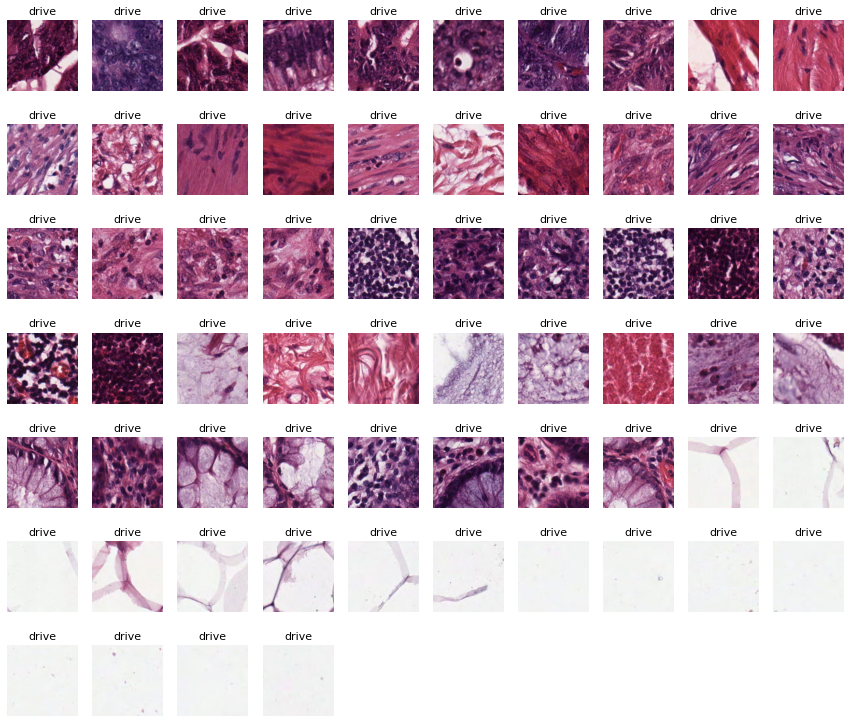

In [ ]:
import matplotlib.pyplot as plt
# plot a grid of 16 images (2 images of each class)
import matplotlib.image as mpimg
#set the number of columns and rows
rows = 8 #2
cols = 10 #8
#set the figure size
fig = plt.gcf()
fig.set_size_inches(15,15)
#merge the covid and normal list
merged_list = tumor_pic+stroma_pic+complex_pic+lympho_pic+debris_pic+mucosa_pic+adipose_pic+empty_pic
for i , img_path in enumerate(merged_list):
  data= img_path.split('/', 8)[2] #8 2
  sp = plt.subplot(rows, cols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  sp.set_title(data, fontsize=11)
  plt.imshow(img,cmap='gray') 

  plt.show

In [ ]:
x = []
y = []

for i in tqdm(os.listdir(train_tumor_dir)):
    path = os.path.join(train_tumor_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('TUMOR')

for i in tqdm(os.listdir(train_adipose_dir)):
    path = os.path.join(train_adipose_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('ADIPOSE')

for i in tqdm(os.listdir(train_complex_dir)):
    path = os.path.join(train_complex_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('COMPLEX')  

for i in tqdm(os.listdir(train_debris_dir)):
    path = os.path.join(train_debris_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('DEBRIS') 

for i in tqdm(os.listdir(train_empty_dir)):
    path = os.path.join(train_empty_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('EMPTY') 

for i in tqdm(os.listdir(train_lympho_dir)):
    path = os.path.join(train_lympho_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('LYMPHO') 

for i in tqdm(os.listdir(train_mucosa_dir)):
    path = os.path.join(train_mucosa_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('MUCOSA')     

for i in tqdm(os.listdir(train_stroma_dir)):
    path = os.path.join(train_stroma_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('STROMA')    

100%|██████████| 500/500 [03:46<00:00,  2.20it/s]


In [ ]:
for i in tqdm(os.listdir(test_tumor_dir)):
    path = os.path.join(test_tumor_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('TUMOR')

for i in tqdm(os.listdir(test_adipose_dir)):
    path = os.path.join(test_adipose_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('ADIPOSE')

for i in tqdm(os.listdir(test_complex_dir)):
    path = os.path.join(test_complex_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('COMPLEX')  

for i in tqdm(os.listdir(test_debris_dir)):
    path = os.path.join(test_debris_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('DEBRIS') 

for i in tqdm(os.listdir(test_empty_dir)):
    path = os.path.join(test_empty_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('EMPTY') 

for i in tqdm(os.listdir(test_lympho_dir)):
    path = os.path.join(test_lympho_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('LYMPHO') 

for i in tqdm(os.listdir(test_mucosa_dir)):
    path = os.path.join(test_mucosa_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('MUCOSA')     

for i in tqdm(os.listdir(test_stroma_dir)):
    path = os.path.join(test_stroma_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(150,150))
    x.append(img)
    y.append('STROMA')

100%|██████████| 63/63 [00:31<00:00,  2.01it/s]


In [ ]:
x = np.array(x)
y = np.array(y)
x.shape,y.shape

((4504, 150, 150, 3), (4504,))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


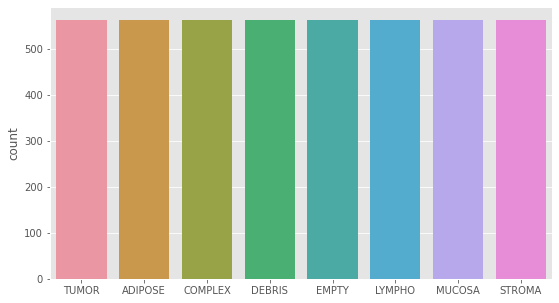

In [ ]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(9,5))
sns.countplot(y)
plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
y = to_categorical(y)#num_classes = 8
y.shape

(4504, 8)

In [ ]:
from sklearn.utils import shuffle
x,y = shuffle(x,y)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
y_test.shape

(901, 8)

**Data Augmentation**

The amount of data gathered was very low and could cause the models to under-fit. Hence, we would use a brilliant technique of Data Augmentation to increase the amount of data. This technique relies on rotations, flips, change in exposure, etc to create similar images. Using this technique we can increase the size of data by a high factor. The output image of the cropping stage is given as input to ImageDataGenerator which is a function in keras.preprocessing.image library. This function takes multiple arguments that decide how Augmentation takes place.

In [ ]:
# generate training,testing and validation batches 
dgen_train = ImageDataGenerator(rescale =1./255,
                                validation_split=0.2,
                                zoom_range = 0.2,
                                horizontal_flip =True)
dgen_validation = ImageDataGenerator(rescale = 1./255)
dgen_test = ImageDataGenerator(rescale =1./255)

train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=(150,150),
                                                 subset='training',
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=(150,150),
                                                 subset='validation',
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_generator = dgen_test.flow_from_directory(test_dir,
                                                 target_size=(150,150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
Found 504 images belonging to 8 classes.


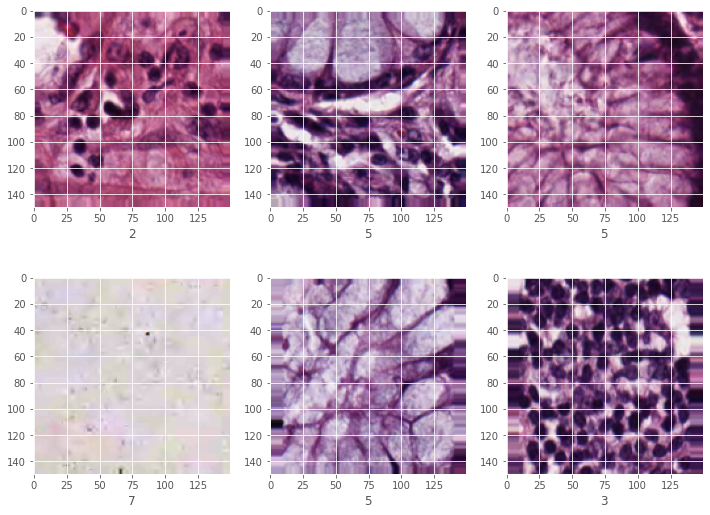

In [ ]:
from tensorflow.keras.preprocessing import image
sample_x,sample_y = next(train_generator)
plt.figure(figsize=(12,9))
for i in range(6):
    plt.subplot(2,3,i+1)
    sample = image.array_to_img(sample_x[i])
    plt.xlabel(np.argmax(sample_y[i]))
    plt.imshow(sample)
plt.show()

In [ ]:
#get the class indices
train_generator.class_indices

{'01_TUMOR': 0,
 '02_STROMA': 1,
 '03_COMPLEX': 2,
 '04_LYMPHO': 3,
 '05_DEBRIS': 4,
 '06_MUCOSA': 5,
 '07_ADIPOSE': 6,
 '08_EMPTY': 7}

In [ ]:
#get the image shape
train_generator.image_shape

(150, 150, 3)

In [ ]:
#get the class indices
train_generator.class_indices

{'01_TUMOR': 0,
 '02_STROMA': 1,
 '03_COMPLEX': 2,
 '04_LYMPHO': 3,
 '05_DEBRIS': 4,
 '06_MUCOSA': 5,
 '07_ADIPOSE': 6,
 '08_EMPTY': 7}

**Model architecture**

VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.


In [ ]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D,BatchNormalization,LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

import keras.backend as K
from sklearn import metrics

from typeguard import typechecked
from typing import Optional

import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

checkpoint_2 = ModelCheckpoint( "VGG16" ,monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
checkpoint_3 = ModelCheckpoint( "TL VGG16" ,monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [ ]:
model_1 = models.Sequential()
model_1.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=(150,150,3)))
model_1.add(layers.Conv2D(64, 3, strides=1, padding='same'))
model_1.add(layers.Activation('relu'))
model_1.add(layers.Conv2D(64, 3, strides=1, padding='same'))
model_1.add(layers.Activation('relu'))
model_1.add(layers.MaxPooling2D(2, strides=2))
model_1.add(layers.Conv2D(128, 3, strides=1, padding='same'))
model_1.add(layers.Activation('relu'))
model_1.add(layers.Conv2D(128, 3, strides=1, padding='same'))
model_1.add(layers.Activation('relu'))
model_1.add(layers.MaxPooling2D(2, strides=2))
model_1.add(layers.Conv2D(256, 3, strides=1, padding='same'))
model_1.add(layers.Activation('relu'))
model_1.add(layers.Conv2D(256, 3, strides=1, padding='same'))
model_1.add(layers.Activation('relu'))
model_1.add(layers.Conv2D(256, 1, strides=1, padding='same'))
model_1.add(layers.Activation('relu'))
model_1.add(layers.MaxPooling2D(2, strides=2))
model_1.add(layers.Conv2D(512, 3, strides=1, padding='same'))
model_1.add(layers.Activation('relu'))
model_1.add(layers.Conv2D(512, 3, strides=1, padding='same'))
model_1.add(layers.Activation('relu'))
model_1.add(layers.Conv2D(512, 1, strides=1, padding='same'))
model_1.add(layers.Activation('relu'))
model_1.add(layers.MaxPooling2D(2, strides=2))
model_1.add(layers.Conv2D(512, 3, strides=1, padding='same'))
model_1.add(layers.Activation('relu'))
model_1.add(layers.Conv2D(512, 3, strides=1, padding='same'))
model_1.add(layers.Activation('relu'))
model_1.add(layers.Conv2D(512, 1, strides=1, padding='same'))
model_1.add(layers.Activation('relu'))
model_1.add(layers.MaxPooling2D(2, strides=2))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(4096, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(4096, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(8, activation='softmax'))
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

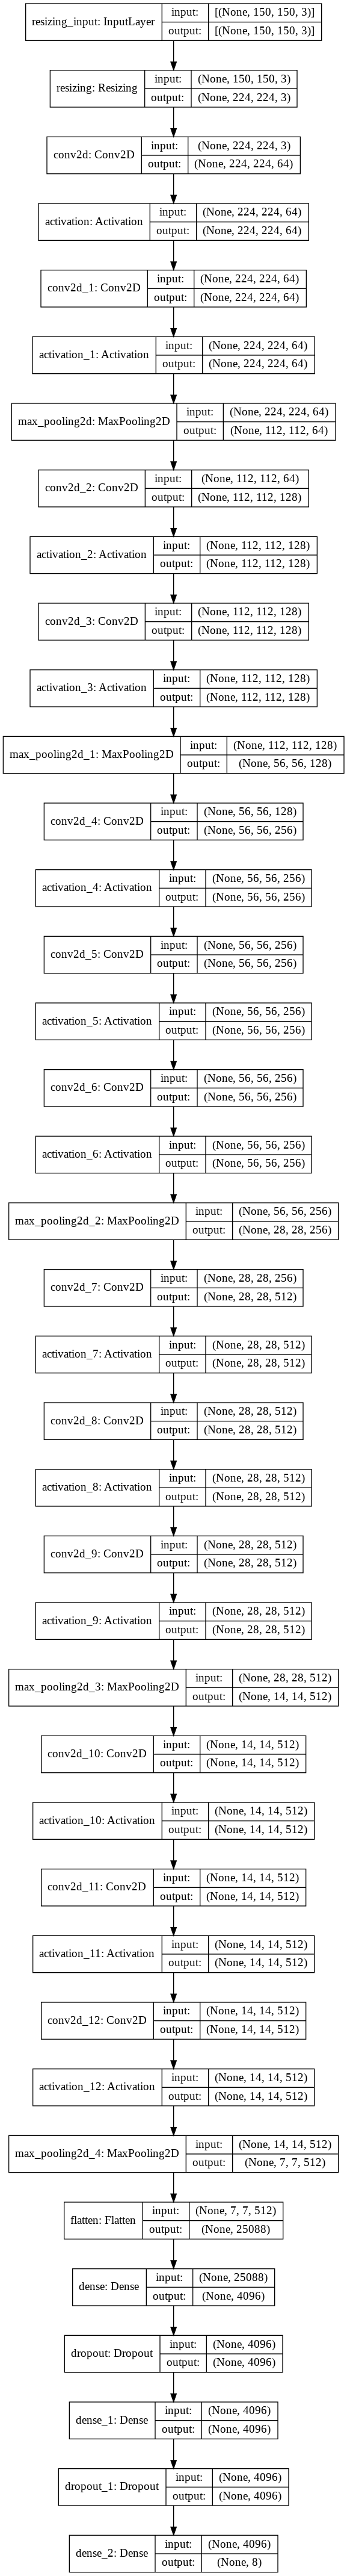

In [ ]:
plot_model(model_1, 'VGG16 model.png', show_shapes=True)

**Compiling and training the model**

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model_1.compile(optimizer=Adam(lr=0.0001),loss="categorical_crossentropy",metrics = ["accuracy"])

In [ ]:
#train the VGG16 model
history_1 = model_1.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100, 
                        validation_data=(x_test, y_test),
                        callbacks=checkpoint_2)

Epoch 1/100
113/113 [==============================] - 38s 150ms/step - loss: 1.8088 - accuracy: 0.2546 - val_loss: 1.2316 - val_accuracy: 0.4040

Epoch 00001: val_accuracy improved from -inf to 0.40400, saving model to VGG16
INFO:tensorflow:Assets written to: VGG16/assets
Epoch 2/100
113/113 [==============================] - 13s 119ms/step - loss: 1.1342 - accuracy: 0.4960 - val_loss: 0.9770 - val_accuracy: 0.5205

Epoch 00002: val_accuracy improved from 0.40400 to 0.52053, saving model to VGG16
INFO:tensorflow:Assets written to: VGG16/assets
Epoch 3/100
113/113 [==============================] - 13s 119ms/step - loss: 0.9965 - accuracy: 0.5905 - val_loss: 1.0374 - val_accuracy: 0.5394

Epoch 00003: val_accuracy improved from 0.52053 to 0.53940, saving model to VGG16
INFO:tensorflow:Assets written to: VGG16/assets
Epoch 4/100
113/113 [==============================] - 14s 120ms/step - loss: 0.9355 - accuracy: 0.5777 - val_loss: 0.6524 - val_accuracy: 0.7691

Epoch 00004: val_accuracy

**Model Performance Evaluation**


In [ ]:
#get the keys of history object

history_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

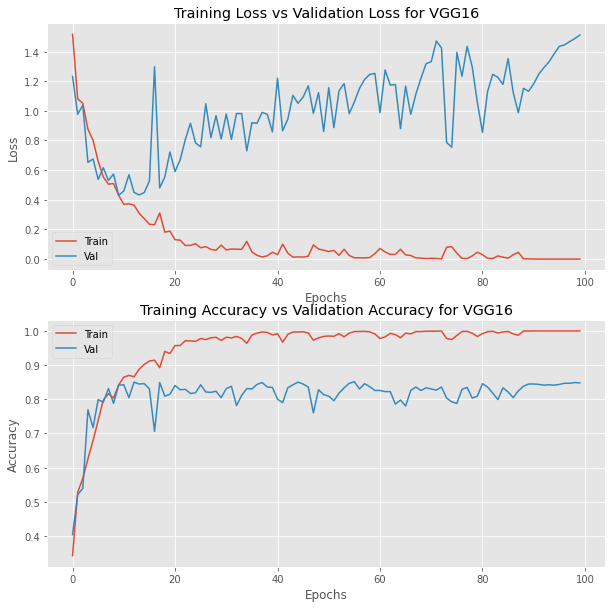

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history_1.history['loss'])
axs[0].plot(history_1.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss for VGG16')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])
axs[1].plot(history_1.history['accuracy'])
axs[1].plot(history_1.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy for VGG16')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

Metrics for Training-Validation accuracy/loss.

In [ ]:
print('VGG16 accuracy:', history_1.history['accuracy'][-1])
print('VGG16 validation accuracy:', history_1.history['val_accuracy'][-1])
print('VGG16 loss:', history_1.history['loss'][-1])
print('VGG16 validation loss:', history_1.history['val_loss'][-1])

VGG16 accuracy: 1.0
VGG16 validation accuracy: 0.8479467034339905
VGG16 loss: 9.52999744185945e-06
VGG16 validation loss: 1.5114248991012573


**Transfer Learning and fine tuning**

It is a machine learning method where we apply a pre-trained model as a starting point for developing another model for a similar task. The form of transfer learning used in deep learning is an inductive transfer, that refers to the ability of a learning mechanism to improve performance on the current task after having learned a different but related concept or skill on a previous task.
In this approach of transfer learning, the whole model is trained on the available target dataset, and weights are fine-tuned using backpropagation. To reduce the computational cost, it’s also possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portions of the network. In this case, we utilize the knowledge in terms of the overall architecture of the network and use its states as the starting point for our retraining step. This, in turn, helps us achieve better performance with less training time.

In [ ]:
base_model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (150,150,3))
for layer in base_model.layers:
  layer.trainable = False
base_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
from keras.models import Sequential,load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D,BatchNormalization,LayerNormalization
from tensorflow.keras import datasets, layers, models, losses, Model

In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(8, activation = 'softmax')(x)
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer=Adam(lr=0.0001),loss="categorical_crossentropy",metrics = ["accuracy"])

In [ ]:
head_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

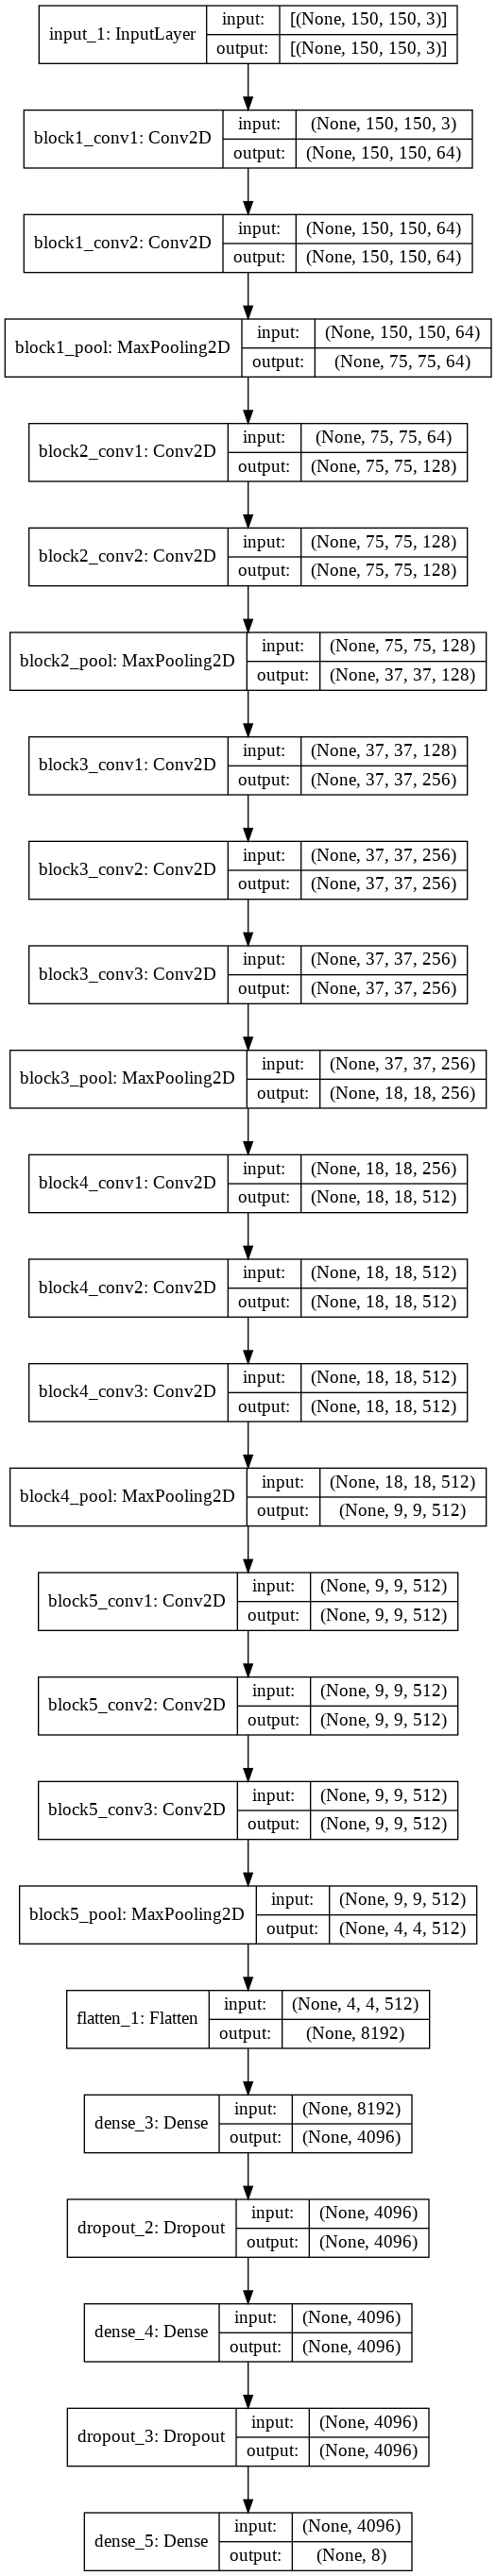

In [ ]:
plot_model(head_model, 'TL VGG16 model.png', show_shapes=True)

**Compiling and training the model**

In [ ]:
history_2=head_model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100, 
                        validation_data=(x_test, y_test),
                        callbacks=checkpoint_3)

Epoch 1/100
113/113 [==============================] - 6s 41ms/step - loss: 7.6037 - accuracy: 0.5249 - val_loss: 1.6553 - val_accuracy: 0.8269

Epoch 00001: val_accuracy improved from -inf to 0.82686, saving model to TL VGG16
INFO:tensorflow:Assets written to: TL VGG16/assets
Epoch 2/100
113/113 [==============================] - 3s 30ms/step - loss: 1.9736 - accuracy: 0.8042 - val_loss: 1.5822 - val_accuracy: 0.8435

Epoch 00002: val_accuracy improved from 0.82686 to 0.84351, saving model to TL VGG16
INFO:tensorflow:Assets written to: TL VGG16/assets
Epoch 3/100
113/113 [==============================] - 3s 29ms/step - loss: 0.9307 - accuracy: 0.8827 - val_loss: 1.1010 - val_accuracy: 0.8590

Epoch 00003: val_accuracy improved from 0.84351 to 0.85905, saving model to TL VGG16
INFO:tensorflow:Assets written to: TL VGG16/assets
Epoch 4/100
113/113 [==============================] - 3s 29ms/step - loss: 0.6239 - accuracy: 0.9031 - val_loss: 1.1777 - val_accuracy: 0.8713

Epoch 00004: va

**Model Performance Evaluation**

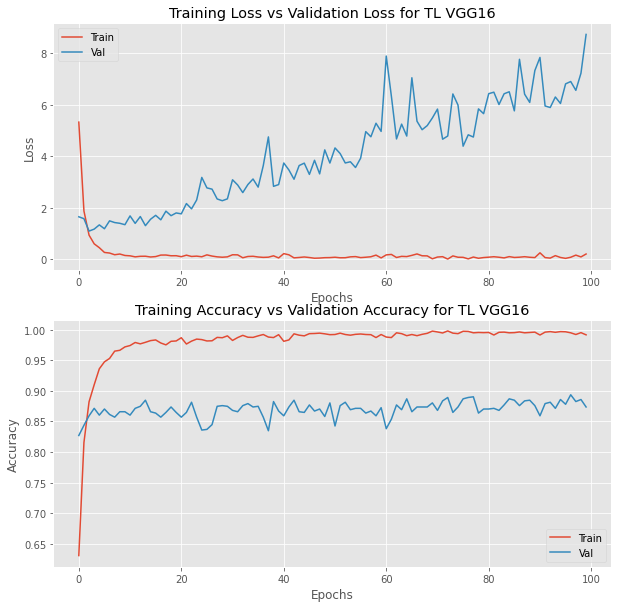

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history_2.history['loss'])
axs[0].plot(history_2.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss for TL VGG16')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])
axs[1].plot(history_2.history['accuracy'])
axs[1].plot(history_2.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy for TL VGG16')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
print('VGG16 accuracy:', history_2.history['accuracy'][-1])
print('VGG16 validation accuracy:', history_2.history['val_accuracy'][-1])
print('VGG16 loss:', history_2.history['loss'][-1])
print('VGG16 validation loss:', history_2.history['val_loss'][-1])

VGG16 accuracy: 0.9913960695266724
VGG16 validation accuracy: 0.8734739422798157
VGG16 loss: 0.21251557767391205
VGG16 validation loss: 8.72675609588623


In [ ]:
model_1.evaluate(x_test, y_test)

29/29 [==============================] - 1s 32ms/step - loss: 1.5114 - accuracy: 0.8479


[1.5114248991012573, 0.8479467034339905]

In [ ]:
head_model.evaluate(x_test, y_test)

29/29 [==============================] - 1s 21ms/step - loss: 8.7268 - accuracy: 0.8735


[8.72675609588623, 0.8734739422798157]

**Confusion Matrix**

Now it's time to assess the performances of the two models predicting on new data, by firstly create the correspondant confusion matrix.

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

*VGG16 confusion matrix*

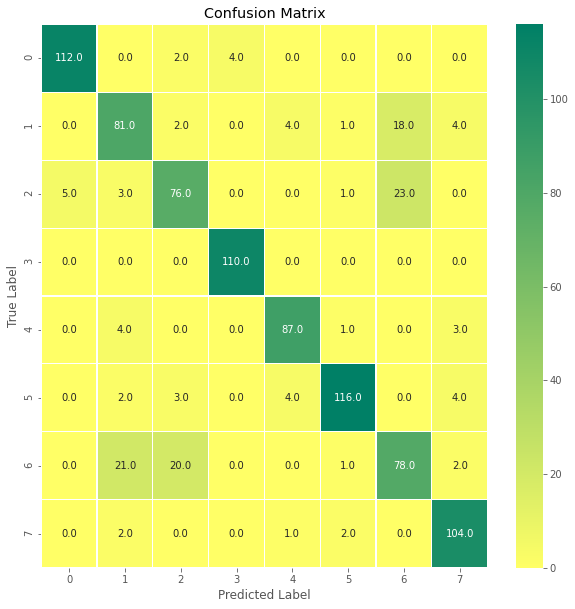

In [ ]:
# Predict the values from the test dataset
Y_pred = model_1.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert test observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="summer_r", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

*VGG16 +  transfer learning confusion matrix*

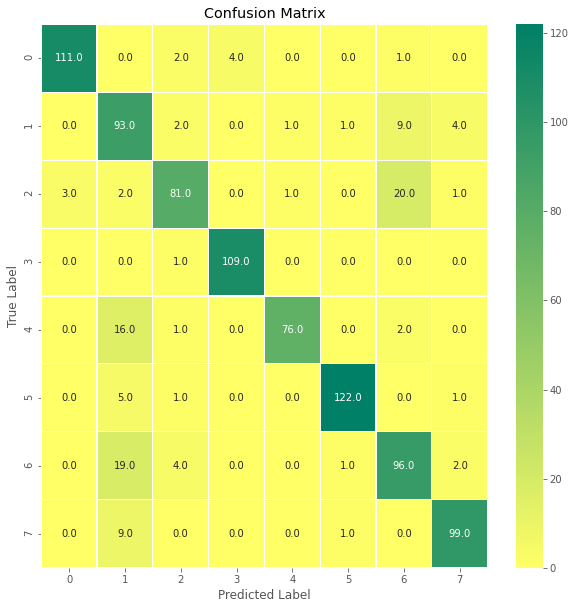

In [ ]:
# Predict the values from the test dataset
Y_pred = head_model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert test observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="summer_r", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**Prediction On New Data**

No we analyse precision, recall, F1-scores to preict on new data.

*VGG16 model*

In [ ]:
y_pred_1 = model_1.predict(x_test)
y_pred_1 = np.argmax(y_pred_1,axis=1)
unique_1,counts_1 = np.unique(y_pred_1,return_counts=True)
print(unique_1,counts_1)
y_test_new_1 = np.argmax(y_test,axis=1)

[0 1 2 3 4 5 6 7] [117 113 103 114  96 122 119 117]


In [ ]:
clf_report_1 = classification_report(y_test_new_1,y_pred_1)
print(clf_report_1)

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       118
           1       0.72      0.74      0.73       110
           2       0.74      0.70      0.72       108
           3       0.96      1.00      0.98       110
           4       0.91      0.92      0.91        95
           5       0.95      0.90      0.92       129
           6       0.66      0.64      0.65       122
           7       0.89      0.95      0.92       109

    accuracy                           0.85       901
   macro avg       0.85      0.85      0.85       901
weighted avg       0.85      0.85      0.85       901



*VGG16 + transfer learning*

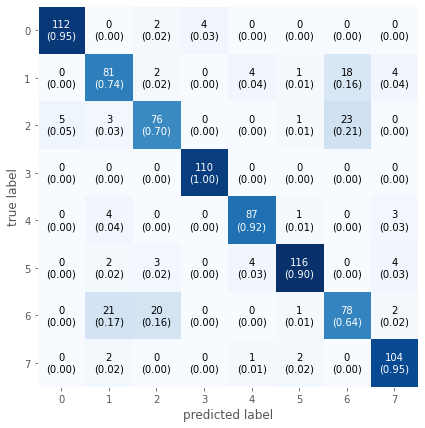

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm_1 = confusion_matrix(y_test_new_1,y_pred_1)
plot_confusion_matrix(conf_mat = cm_1,figsize=(8,7),
                     show_normed=True);

In [ ]:
y_pred_2 = head_model.predict(x_test)
y_pred_2 = np.argmax(y_pred_2,axis=1)
unique_2,counts_2 = np.unique(y_pred_2,return_counts=True)
print(unique_2,counts_2)
y_test_new_2 = np.argmax(y_test,axis=1)

[0 1 2 3 4 5 6 7] [114 144  92 113  78 125 128 107]


In [ ]:
clf_report_2 = classification_report(y_test_new_2,y_pred_2)
print(clf_report_2)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       118
           1       0.65      0.85      0.73       110
           2       0.88      0.75      0.81       108
           3       0.96      0.99      0.98       110
           4       0.97      0.80      0.88        95
           5       0.98      0.95      0.96       129
           6       0.75      0.79      0.77       122
           7       0.93      0.91      0.92       109

    accuracy                           0.87       901
   macro avg       0.89      0.87      0.88       901
weighted avg       0.89      0.87      0.88       901



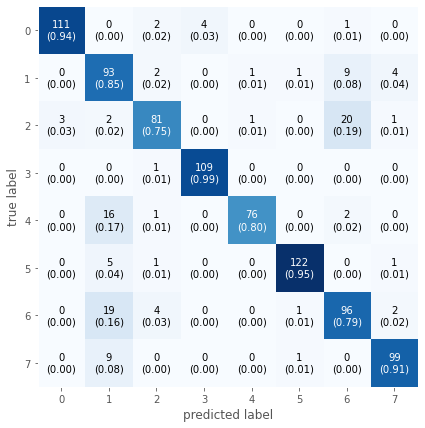

In [ ]:
cm_2 = confusion_matrix(y_test_new_2,y_pred_2)
plot_confusion_matrix(conf_mat = cm_2,figsize=(8,7),
                     show_normed=True);

Now we can finally see how the models performs on new data.

*VGG16 model*

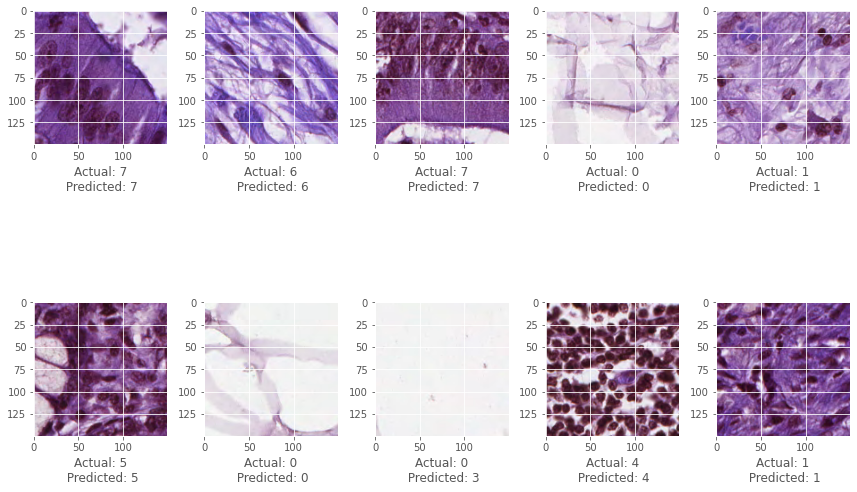

In [ ]:
plt.figure(figsize=(12,9))
for i in range(10):
    sample_idx = random.choice(range(len(x_test)))
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[sample_idx])
    plt.xlabel(f"Actual: {y_test_new_1 [sample_idx]}\n Predicted: {y_pred_1 [sample_idx]}")
    
plt.tight_layout()
plt.show()

*VGG16 model + transfer learning*

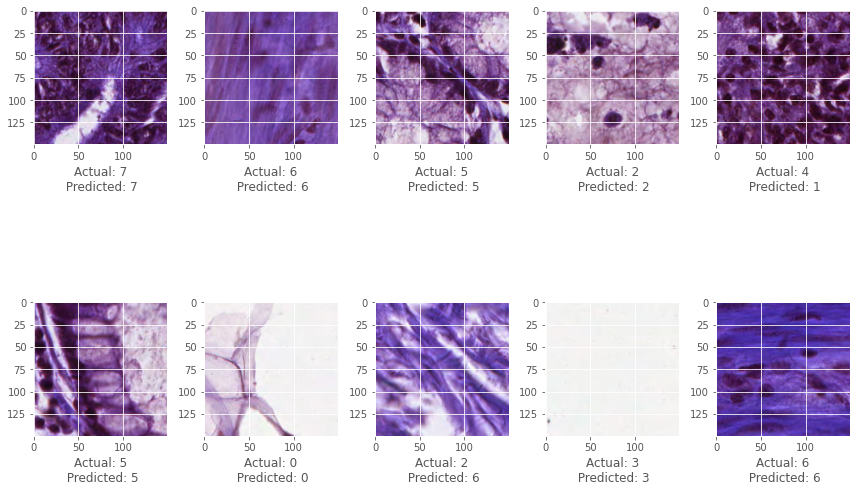

In [ ]:
plt.figure(figsize=(12,9))
for i in range(10):
    sample_idx = random.choice(range(len(x_test)))
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[sample_idx])
    plt.xlabel(f"Actual: {y_test_new_2 [sample_idx]}\n Predicted: {y_pred_2 [sample_idx]}")
    
plt.tight_layout()
plt.show()